# **Geoparsing: Dataset Evaluation**
---
**Prepared by**: Feyi Adesanya, 300120992

**Submission Date**: April 30, 2024

In [2]:
import pandas as pd
import textwrap
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [3]:
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

In [4]:
from Pre.Preprocess import Preprocess
from Gaz.Gazetteer import Gazetteer
from Gaz.BKTree import BKTree

In [5]:
gaz = Gazetteer()

Retrieving Locations Array from Saved Data
Corpus has 133639 Locations
Retrieving BK Tree from Saved Data


In [5]:
preprocess = Preprocess(gaz)
preprocess.extract_train_data()

c:\Users\FeyiA\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Retrieving Corpus from Saved Data
Corpus has 588 documents


# Toponym Analysis

In [6]:
# Dataset Toponyms Metadata
toponyms = [toponym for book in preprocess.corpus for toponym in book.get("toponyms", [])]
df_location = pd.DataFrame(toponyms)
df_location

,phrase,start,end,geonameid,name,fclass,fcode,lat,lon,country,admin1
0,Alexandria,0,10,4314550.0,Alexandria,P,PPL,31.3113,-92.4451,United States,Louisiana
1,Alexandria,109,119,4314550.0,Alexandria,P,PPL,31.3113,-92.4451,United States,Louisiana
2,Rapides Parish,247,261,4338356.0,Rapides Parish,A,ADM2,31.1669,-92.4835,United States,Louisiana
3,Avoyelles,0,9,4315243.0,Avoyelles Parish,A,ADM2,31.0669,-91.9668,United States,Louisiana
4,Cottonport,82,92,4320874.0,Cottonport,P,PPL,30.9841,-92.0535,United States,Louisiana
...,...,...,...,...,...,...,...,...,...,...,...
5083,New Hampshire,1891,1904,5090174.0,New Hampshire,A,ADM1,43.6670,-71.4998,United States,New Hampshire
5084,Iraq,1940,1944,99237.0,Republic of Iraq,A,PCLI,33.0000,44.0000,Iraq,Ostan-e Soleymaniyeh
5085,Afghanistan,1948,1959,1149361.0,Islamic Republic of Afghanistan,A,PCLI,33.0000,65.0000,Afghanistan,None
5086,U.S.,2070,2074,6252001.0,United States,A,PCLI,39.7600,-98.5000,United States,None


In [7]:
import plotly.graph_objects as go

# Get coordinates
# Dataset Global Location Distribution
geoname_coordinates = {}
for book in preprocess.corpus:
    for toponym in book.get("toponyms", []):
        geoname_id = toponym.get("geonameid")
        lat = toponym.get("lat")
        lon = toponym.get("lon")
        if geoname_id is not None and lat is not None and lon is not None:
            geoname_coordinates[toponym["name"]] = (float(lat), float(lon))

# Extract coordinates
locations = list(geoname_coordinates.keys())
lons = [coord[1] for coord in geoname_coordinates.values()]  # Longitude
lats = [coord[0] for coord in geoname_coordinates.values()]  # Latitude

# Create a scatter map
fig = go.Figure(go.Scattermapbox(
    mode="markers+text",
    lon=lons,
    lat=lats,
    marker=go.scattermapbox.Marker(
        size=9,
        color='#3a9571',
    ),
    text=locations,
    textposition="bottom right",
    textfont=dict(
        family="sans serif",
        size=12,
        color="Black"
    )
))

# Set up layout
fig.update_layout(
    title="Local Global Lexicon (LGL) Dataset Location Distribution",
    title_x=0.5,
    mapbox=dict(
        style="carto-positron",
        center=dict(lat=25, lon=0),
        zoom=1,
    ),
    width=1000,
    height=600, 
    margin=dict(l=0, r=0, t=45, b=0),
)

# Show the plot
fig.show()


In [8]:
# Sample Dataset Entry
book = preprocess.corpus[10]
print("Sample Dataset Entry")
print("Text: ", end="")
print(textwrap.fill(book['text'], width=175))
print("Toponyms:")
for i, toponym in enumerate(book['toponyms'], 1):
    print(f"{i}. Name: {toponym['name']}, GeonameID: {toponym.get('geonameid', 'N/A')}, Lat: {toponym.get('lat', 'N/A')}, Lon: {toponym.get('lon', 'N/A')}")


Sample Dataset Entry
Text: Meeting in Alexandria will discuss 2010 census. The town hall meetings, which will take place throughout spring and summer, will include a presentation on organizing local
Complete Count Committees. Complete Count Committees are appointed by the mayor or other elected official and include leaders from the business, education, faith, media, non-
profit, ethnic and other communities. These volunteer committees work together on community events such as festivals, parades, meetings and other activities to keep Minnesota
first in the nation in responding to the census. The 2010 census is critical for Minnesota, which is at risk of losing one of its eight seats in the U.S. House of
Representatives, according to census officials. Census information is also the foundation of equal representation in the state Legislature and determines the allocation of
more than $300 billion in federal funding for everything from education to transportation. The business community al

In [9]:
# Most Common Locations Mentioned
df_common_locations = df_location.groupby(["phrase"]).size().reset_index(name="count")
df_common_locations = df_common_locations.sort_values(by="count", ascending=False)
df_common_locations.columns = ["Location Entity", "Number of Times Used in Dataset"]
df_common_locations = df_common_locations[["Number of Times Used in Dataset","Location Entity"]].head(10)
df_common_locations = df_common_locations.style.set_properties(**{'text-align': 'center'})

#Location Code Descriptions
df_feature_codes_descriptions = pd.read_csv("./data/geo_data/GeoNames/feature_codes.txt", sep="\t", header=None, names=["code", "name", "description"])
df_feature_codes_descriptions['code'] = df_feature_codes_descriptions['code'].str.split('.').str[-1]
type_description_mapping = dict(zip(df_feature_codes_descriptions['code'], df_feature_codes_descriptions['name']))
# Most Common Location Types
df_common_fcodes = df_location["fcode"].value_counts().reset_index()
df_common_fcodes = df_common_fcodes.sort_values(by="count", ascending=False)
df_common_fcodes.columns = ["Location Type", "Number of Times Used in Dataset"]
get_description_lambda = lambda x: next((value for key, value in type_description_mapping.items() if key in x), "Description Not Found")
df_common_fcodes['Description'] = df_common_fcodes['Location Type'].apply(get_description_lambda)
df_common_fcodes = df_common_fcodes[["Number of Times Used in Dataset", "Location Type", "Description"]].head(10)
df_common_fcodes = df_common_fcodes.style.set_properties(**{'text-align': 'center'})

print("Common Trends in Dataset Location Names and Types")
display(HTML('<table><tr>{}</tr></table>'.format(
    '<td>' + df_common_locations.to_html(index=False) + '</td>' +'<td>' + df_common_fcodes.to_html(index=False) + '</td>'
)))

Common Trends in Dataset Location Names and Types


,Number of Times Used in Dataset,Location Entity
1528,84,U.S.
1146,74,Ohio
542,67,Georgia
534,56,Gainesville
1195,55,Paris
1501,52,Texas
736,51,Israel
1325,44,Russia
37,41,American
453,41,Egypt


### Gazetteer Storage

Creating BK Tree
|████████████████████████████████████████| 11/11 [100%] in 0.0s (13047.81/s)    


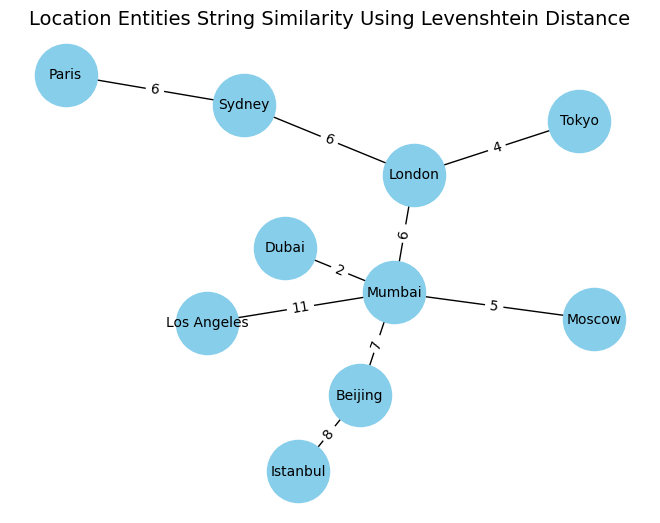

In [10]:
sample_locations = sorted(["New York City", "Tokyo","London","Paris","Beijing","Los Angeles","Moscow","Istanbul","Dubai","Mumbai","Sydney"])
sample_locations = [(city, index) for index, city in enumerate(sample_locations)]
bktree = BKTree(sample_locations, sample=True)
bktree.graph_10_nodes()

# Text Analysis

In [11]:
# Dataset Text Metadata
word_data = {"Document_ID": [], "Word": [], "Labels": []}
for i, book in enumerate(preprocess.corpus):
    iob_tags = book["labels"]
    words = book["text"].split(" ")
    for index in range(len(words)):
        word_data["Document_ID"].append(i)
        word_data["Word"].append(words[index])
        word_data["Labels"].append(iob_tags[index])
df_texts = pd.DataFrame(word_data)
print("Total number of documents in the dataset: {:,}".format(df_texts["Document_ID"].nunique()))
print("Total words in the dataset: {:,}".format(df_texts.shape[0]))
print("Total unique words in the dataset: {:,}".format(len(set(word_data["Word"]))))
print("There are {:,} unique labels in the dataset:".format(len(df_texts["Labels"].unique())), ", ".join(sorted(list(df_texts["Labels"].unique()))))
df_texts

Total number of documents in the dataset: 588
Total words in the dataset: 185,701
Total unique words in the dataset: 29,518
There are 3 unique labels in the dataset: B-LOC, I-LOC, O


,Document_ID,Word,Labels
0,0,Alexandria,B-LOC
1,0,woman,O
2,0,charged,O
3,0,in,O
4,0,connection,O
...,...,...,...
185696,587,much,O
185697,587,better,O
185698,587,than,O
185699,587,I,O


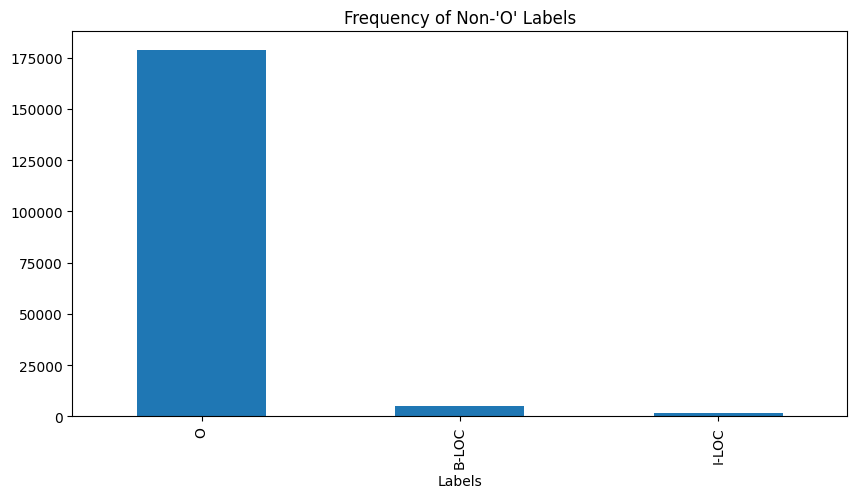

In [12]:
df_texts["Labels"].value_counts().plot(kind="bar", figsize=(10,5))
plt.title("Frequency of Non-'O' Labels")
plt.show()

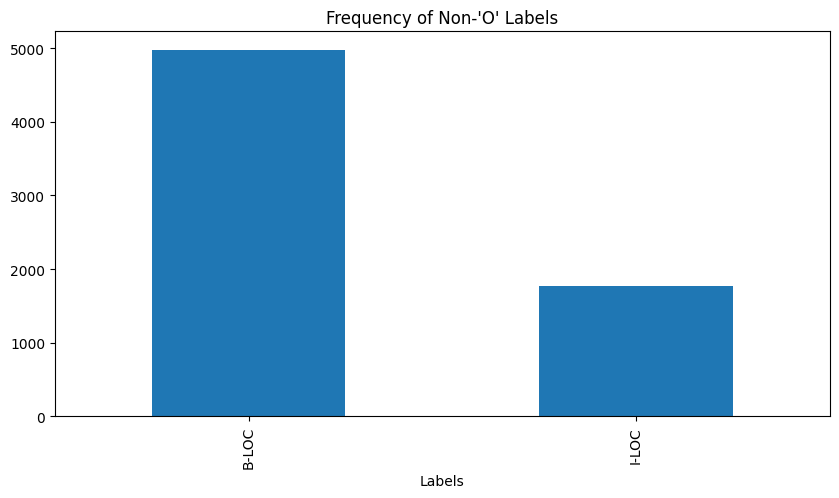

In [13]:
df_texts[df_texts["Labels"]!="O"]["Labels"].value_counts().plot(kind="bar", figsize=(10,5))
plt.title("Frequency of Non-'O' Labels")
plt.show()

C:\Users\FeyiA\AppData\Local\Temp\ipykernel_19620\4259188283.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Max document length is 1488 words


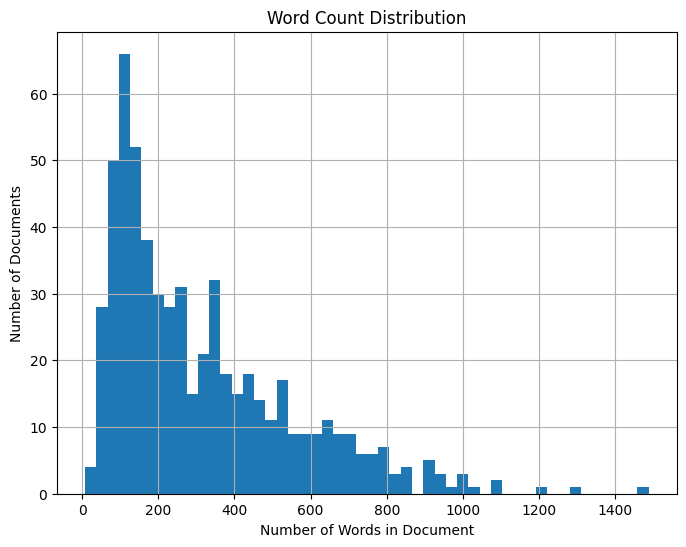

In [14]:
word_counts = df_texts.groupby("Document_ID")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6))
plt.title("Word Count Distribution")
plt.xlabel("Number of Words in Document")
plt.ylabel("Number of Documents")
max_doc_length = word_counts.max()[0]
print(f"Max document length is {max_doc_length} words")
plt.show()